<a href="https://colab.research.google.com/github/lima-breno/time_series/blob/main/TS_11_Sazonais_AutoARIMApassageiros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries temporais estacionárias: AutoARIMA

Este notebook busca uma série temporal de um arquivo escolhido e faz algumas análises preliminares, bem como a aplicação dos modelos SARIMA com seleção automática de $(p,d,q)(P,D,Q)_m$.

Data da última atualização: 10/03/2025

#### Preliminares

In [ ]:
# Carregamento das bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

C:\Users\leopo\.conda\envs\PUCminas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Ajuste das preferências gráficas

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#FFFFFF',    # Cor da moldura
    'axes.facecolor': '#FFFFFF',      # Cor do fundo
    'savefig.facecolor':'#000000',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'grid.color': '#888888',
    'grid.linewidth': '0.1',
    'text.color': '#000000',
    'axes.labelcolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (21,13)

#### Carregamento da Série Temporal

In [ ]:
# Leitura do arquivo de dados

MinhaSerieTemporal = pd.read_csv('Passageiros.csv', index_col = 0)

In [ ]:
# Exibição do DataFrame

MinhaSerieTemporal

,Passageiros (milhares)
Mês,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
# Ajuste do índice para formato DateTime

MinhaSerieTemporal.index = pd.to_datetime(MinhaSerieTemporal.index)

<Axes: xlabel='Mês'>

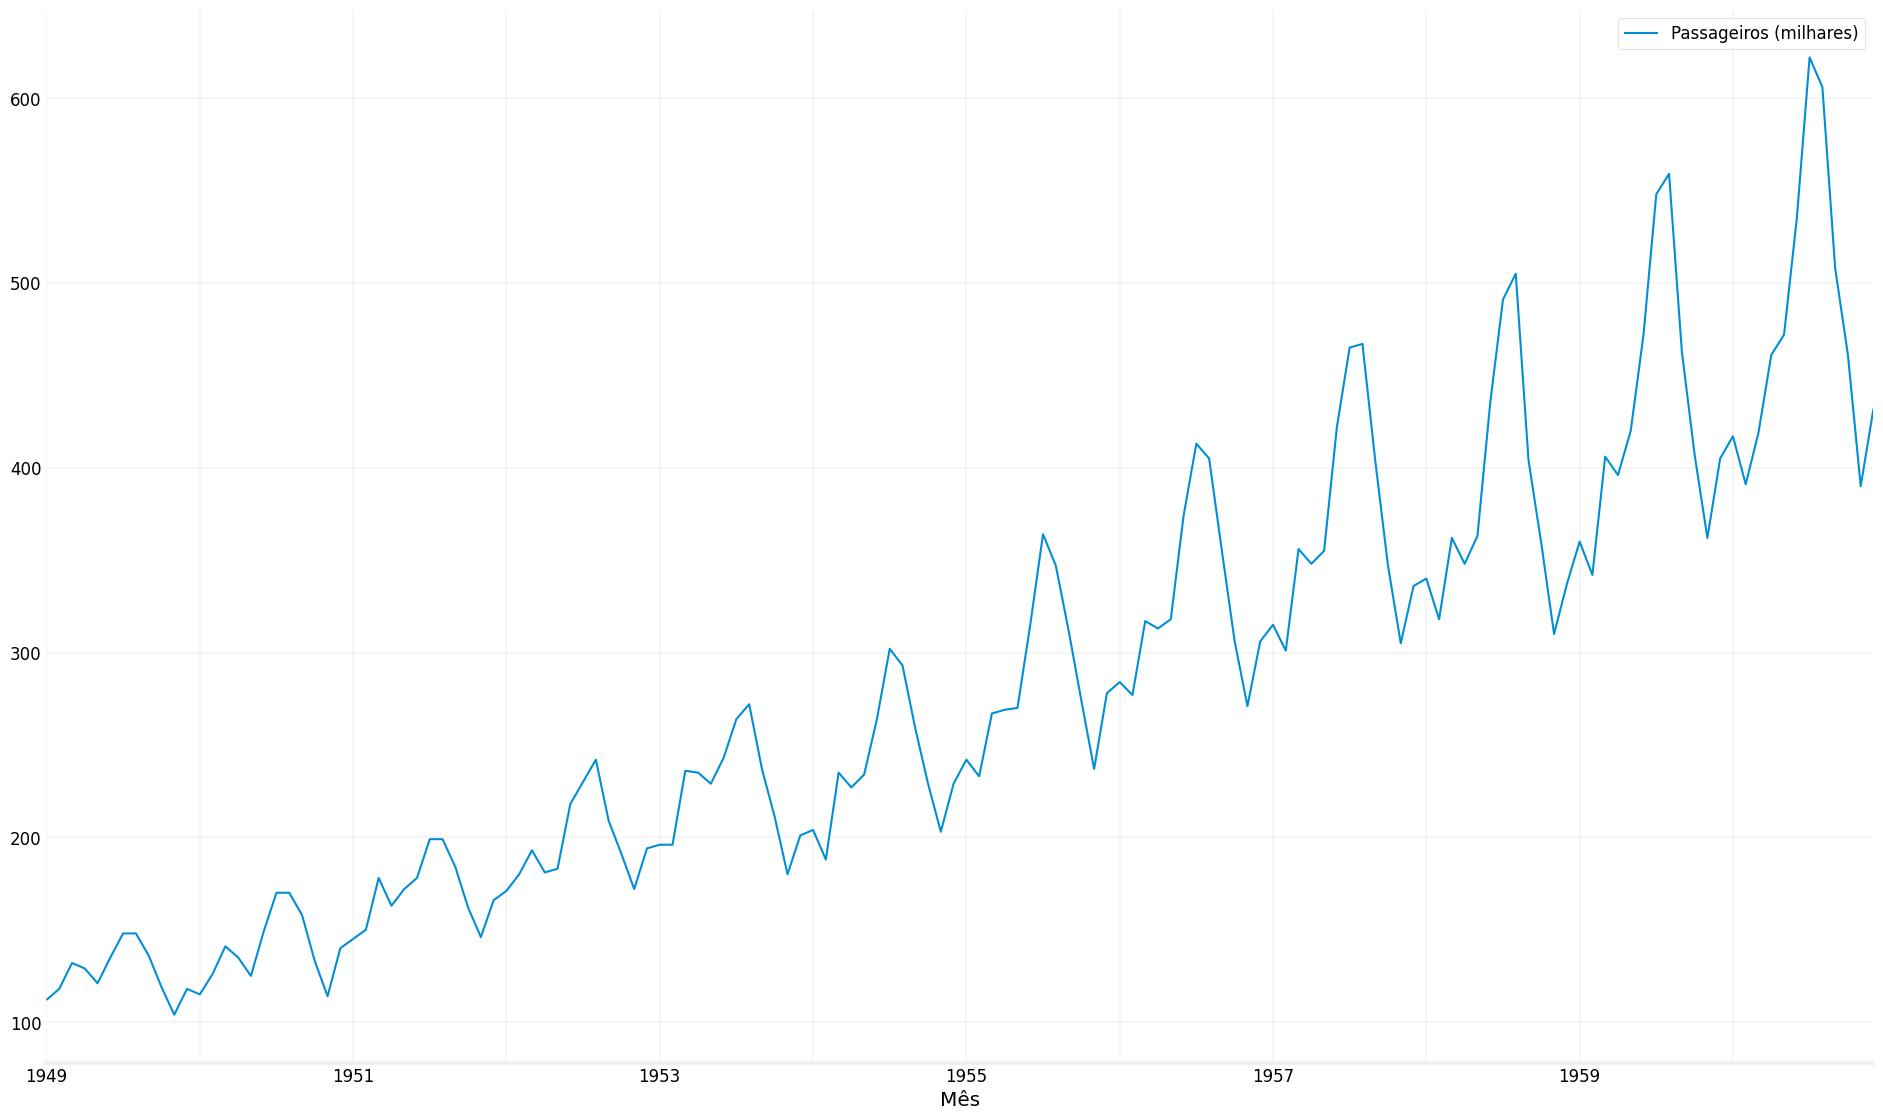

In [ ]:
# Gráfico
MinhaSerieTemporal.plot()

#### Decomposição da Série

In [ ]:
# Decomposição aditiva da série temporal

PeriodoSazonal = 12     # Sazonalidade anual

Decomposicao = seasonal_decompose(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], model = "add", period = PeriodoSazonal)

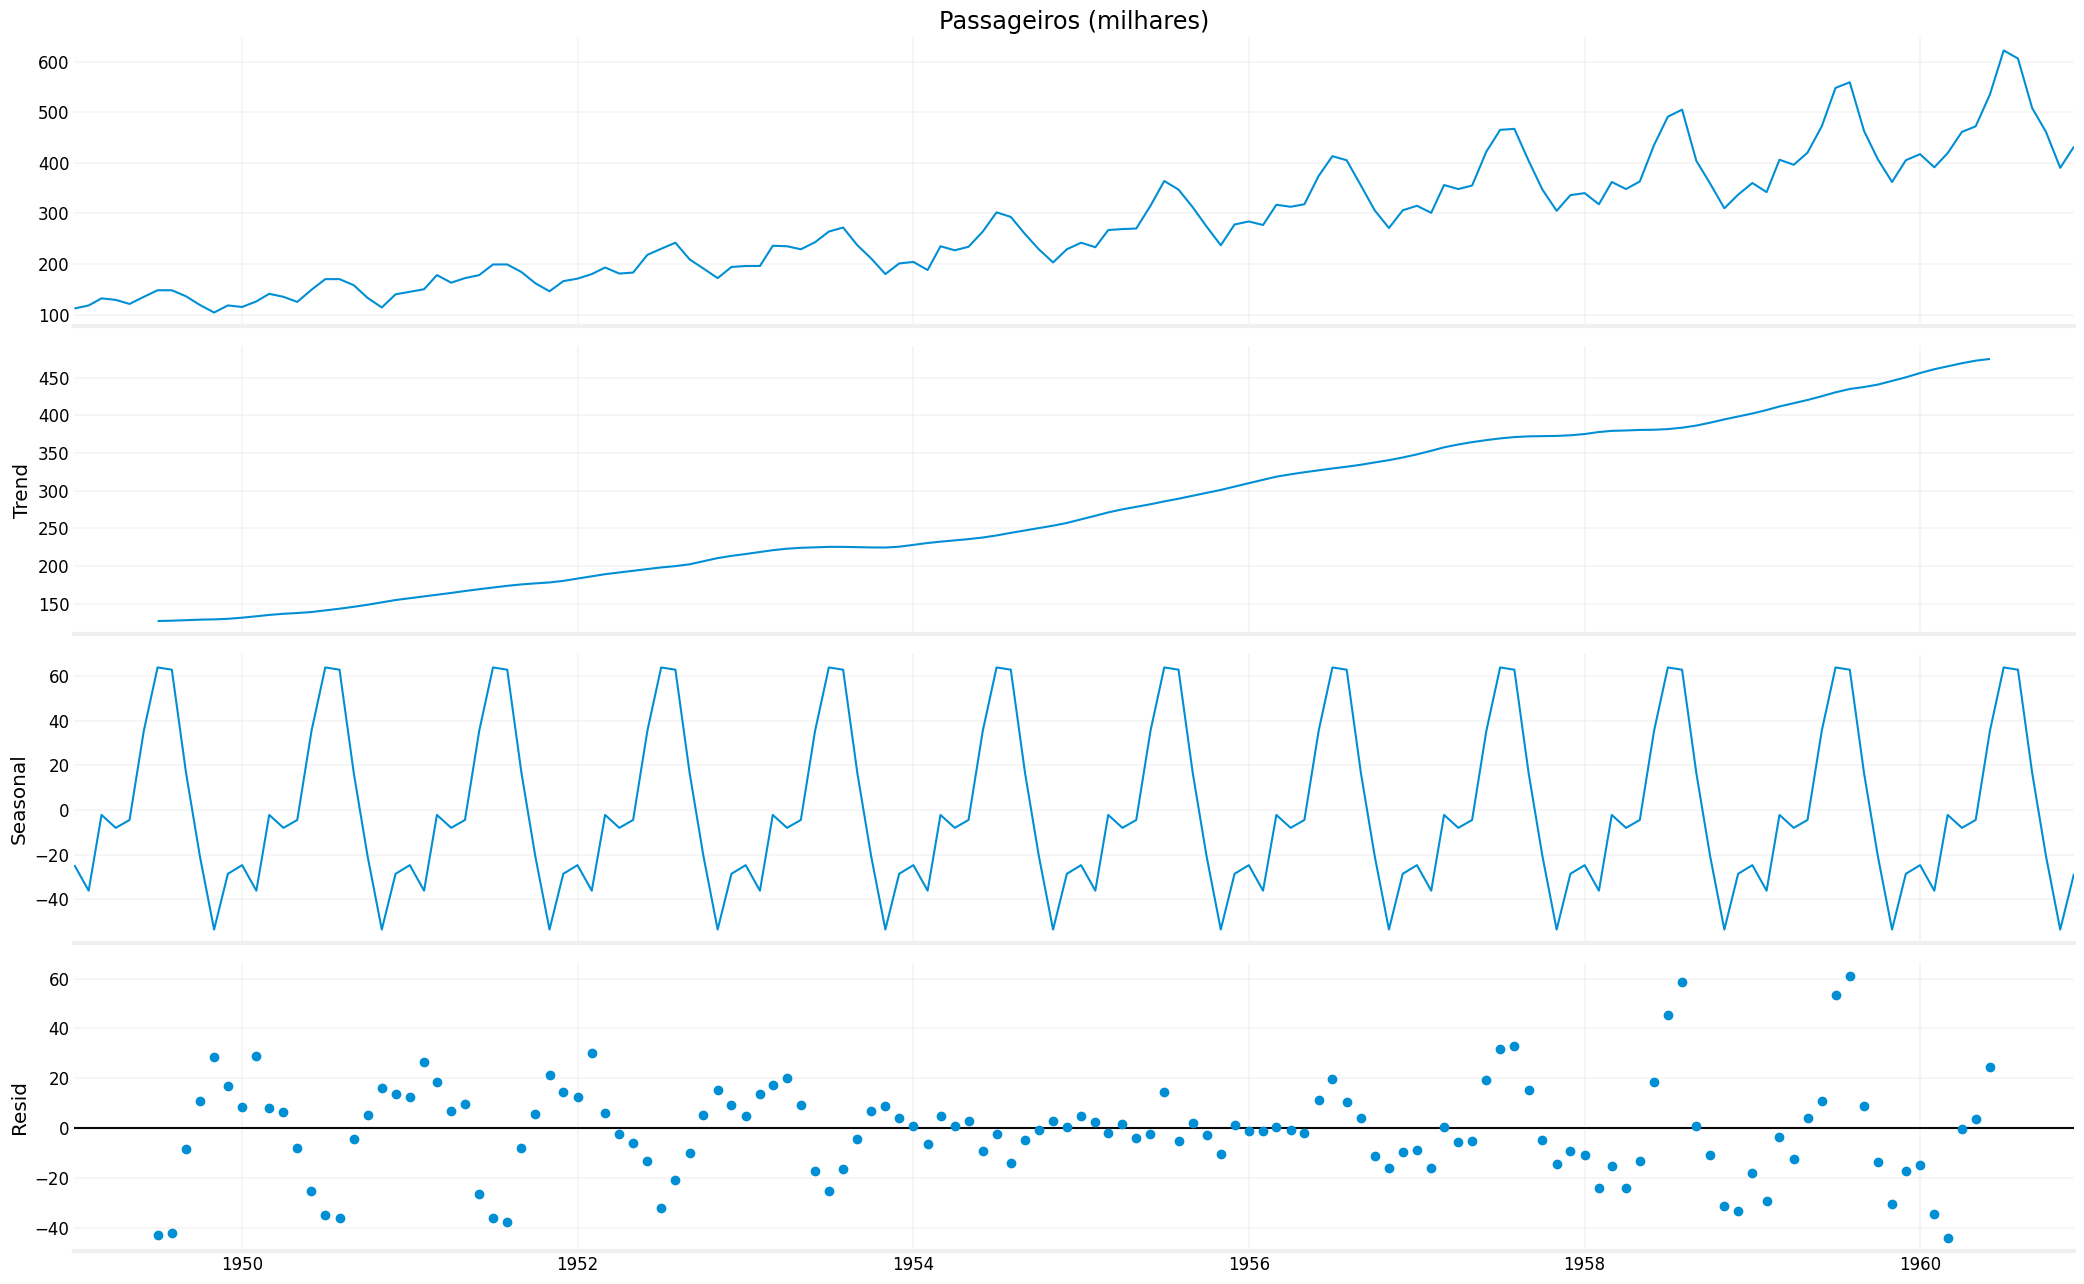

In [ ]:
Decomposicao.plot();

#### Teste ADF

In [ ]:
# Teste ADF para estacionariedade

ad_fuller_result = adfuller(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]])

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: 0.8154
p-value:          99.1880 %


In [ ]:
# Teste ADF para estacionariedade para a série das diferenças finitas de ordem escolhida

OrdemDif = 2

ad_fuller_result = adfuller(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif))

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: -16.3842
p-value:          0.0000 %


#### Funcão de autocorrelação

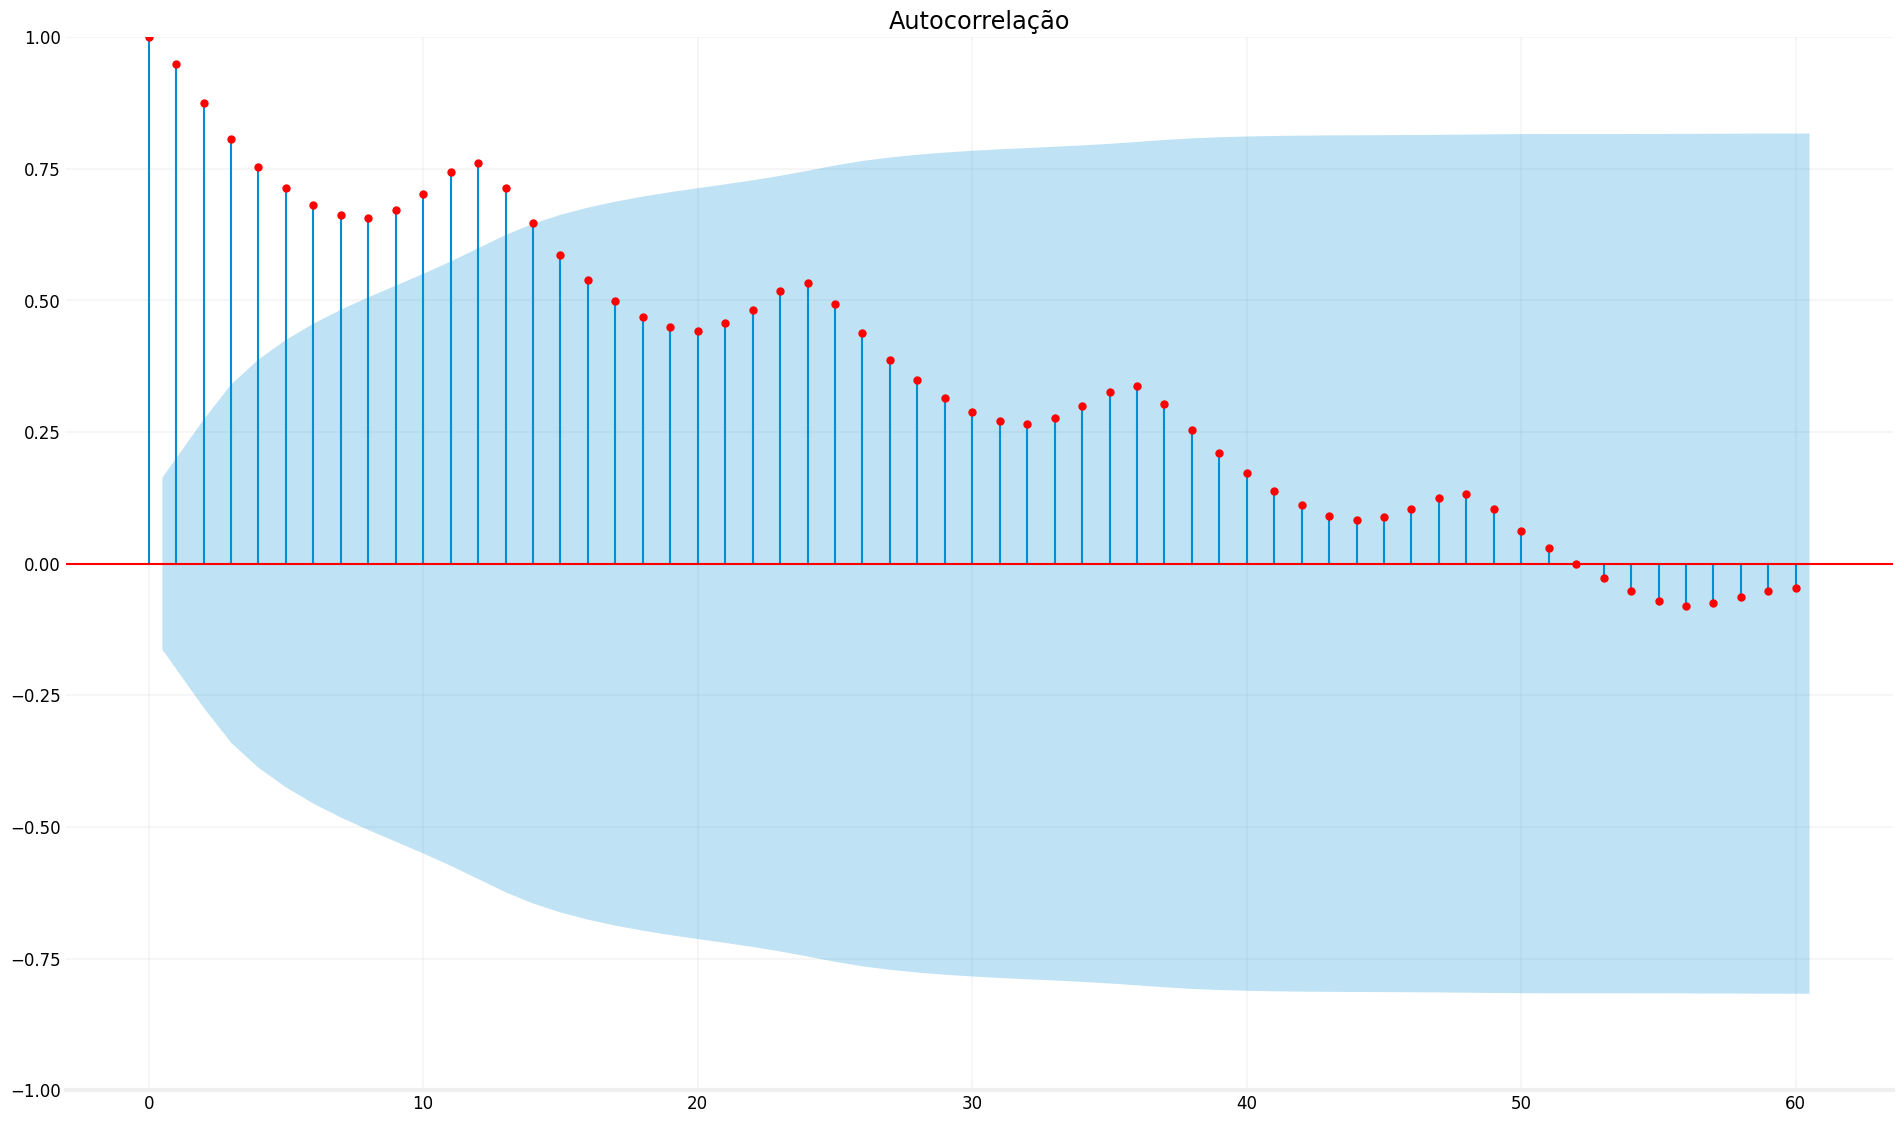

In [ ]:
# Função de correlação para série temporal

plot_acf(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]],  lags=60, title = "Autocorrelação", color="red");

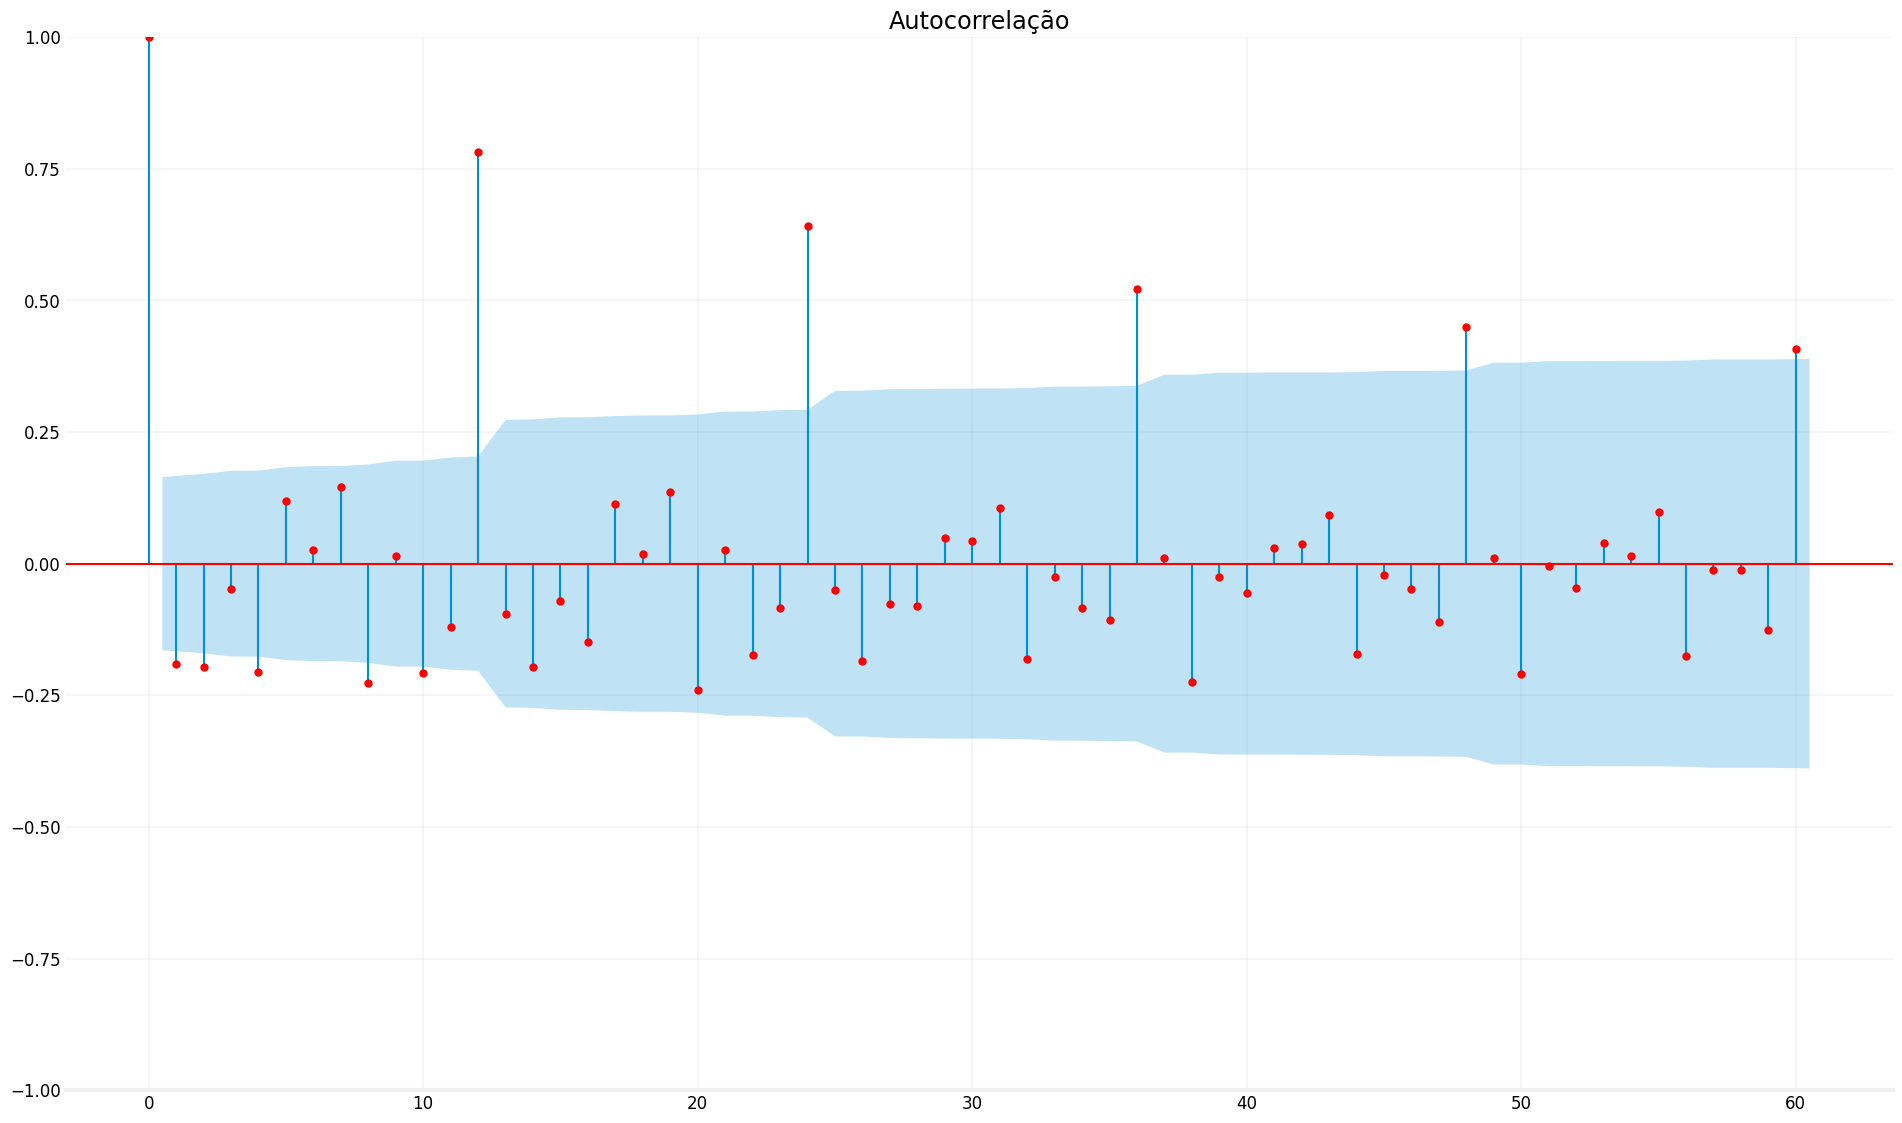

In [ ]:
# Função de correlação para série das diferenças finitas da ordem escolhida acima

plot_acf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=60, title = "Autocorrelação", color="red");

#### Funcão de autocorrelação parcial

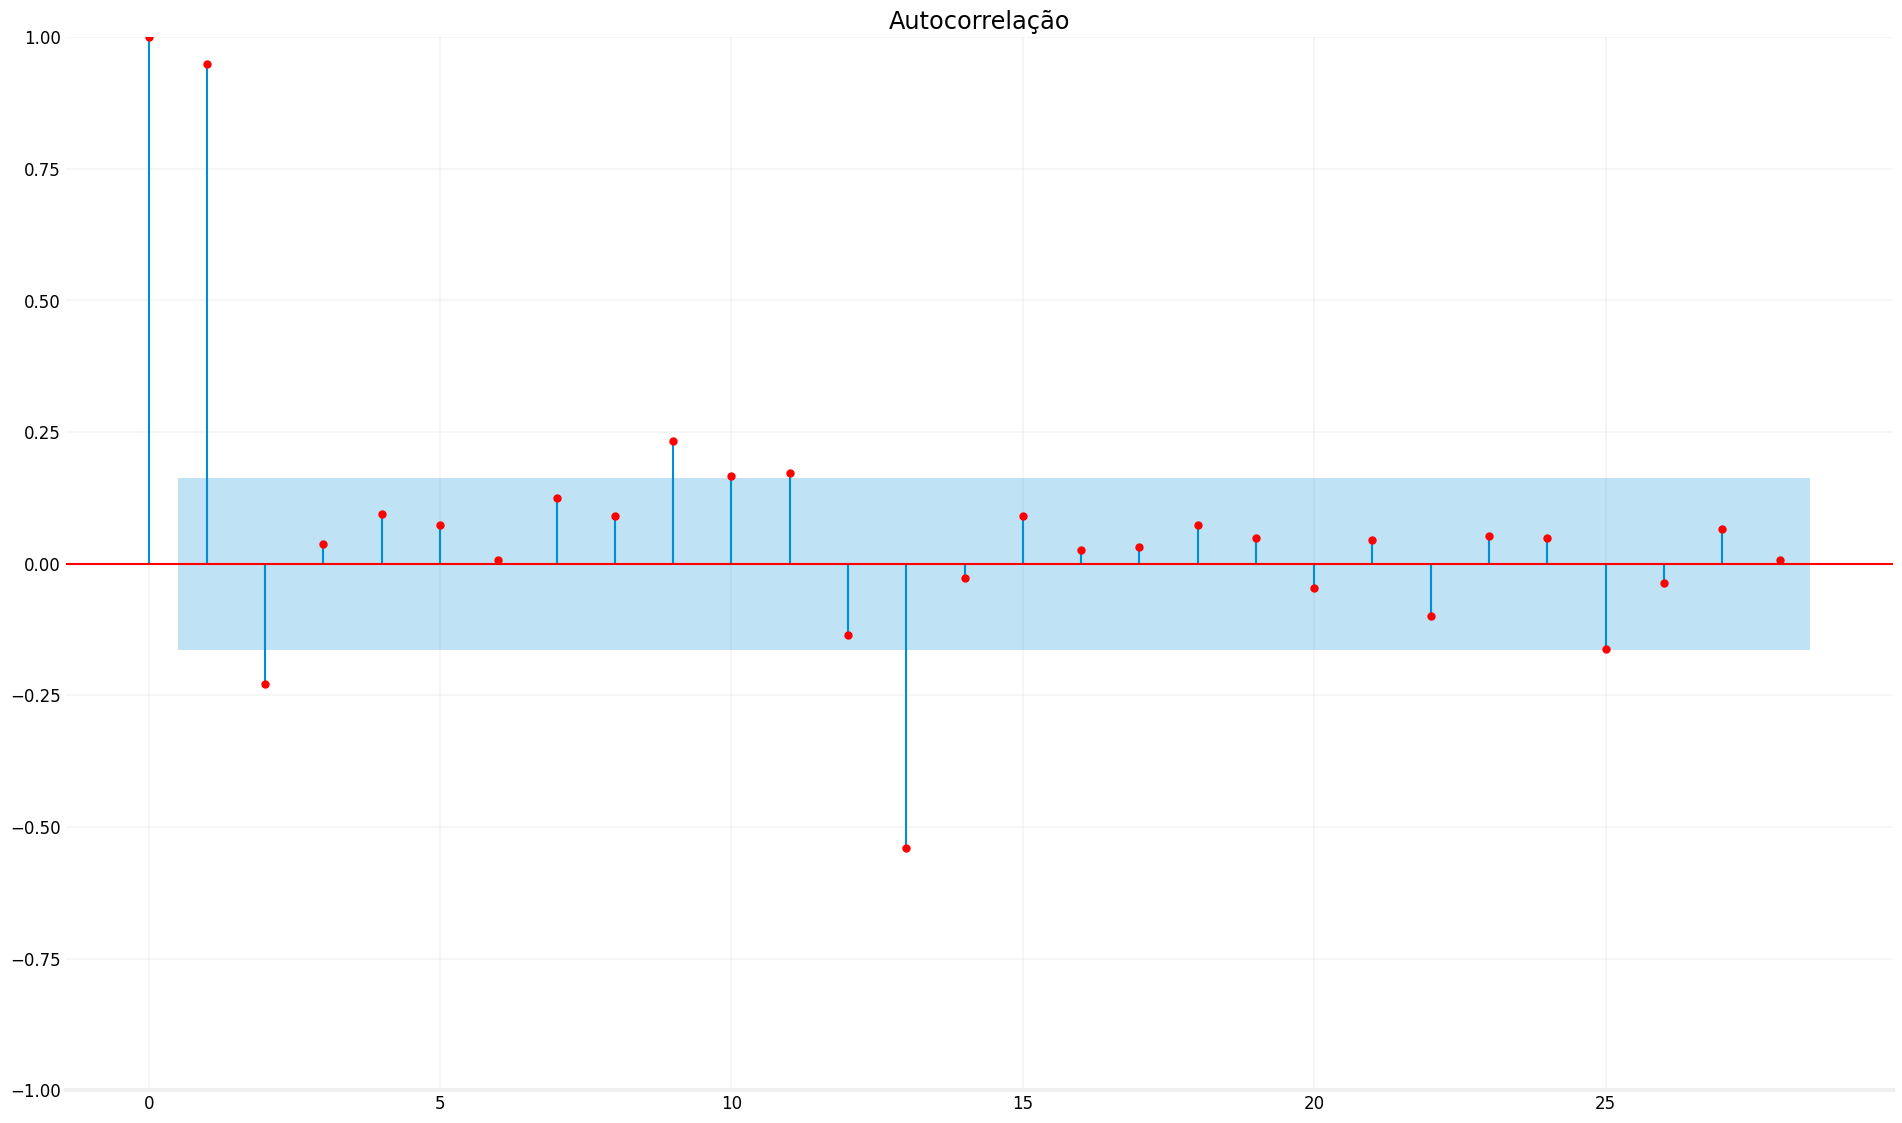

In [ ]:
# Função de correlação parcial para série temporal

plot_pacf(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]],  lags=60
          , title = "Autocorrelação", color="red");

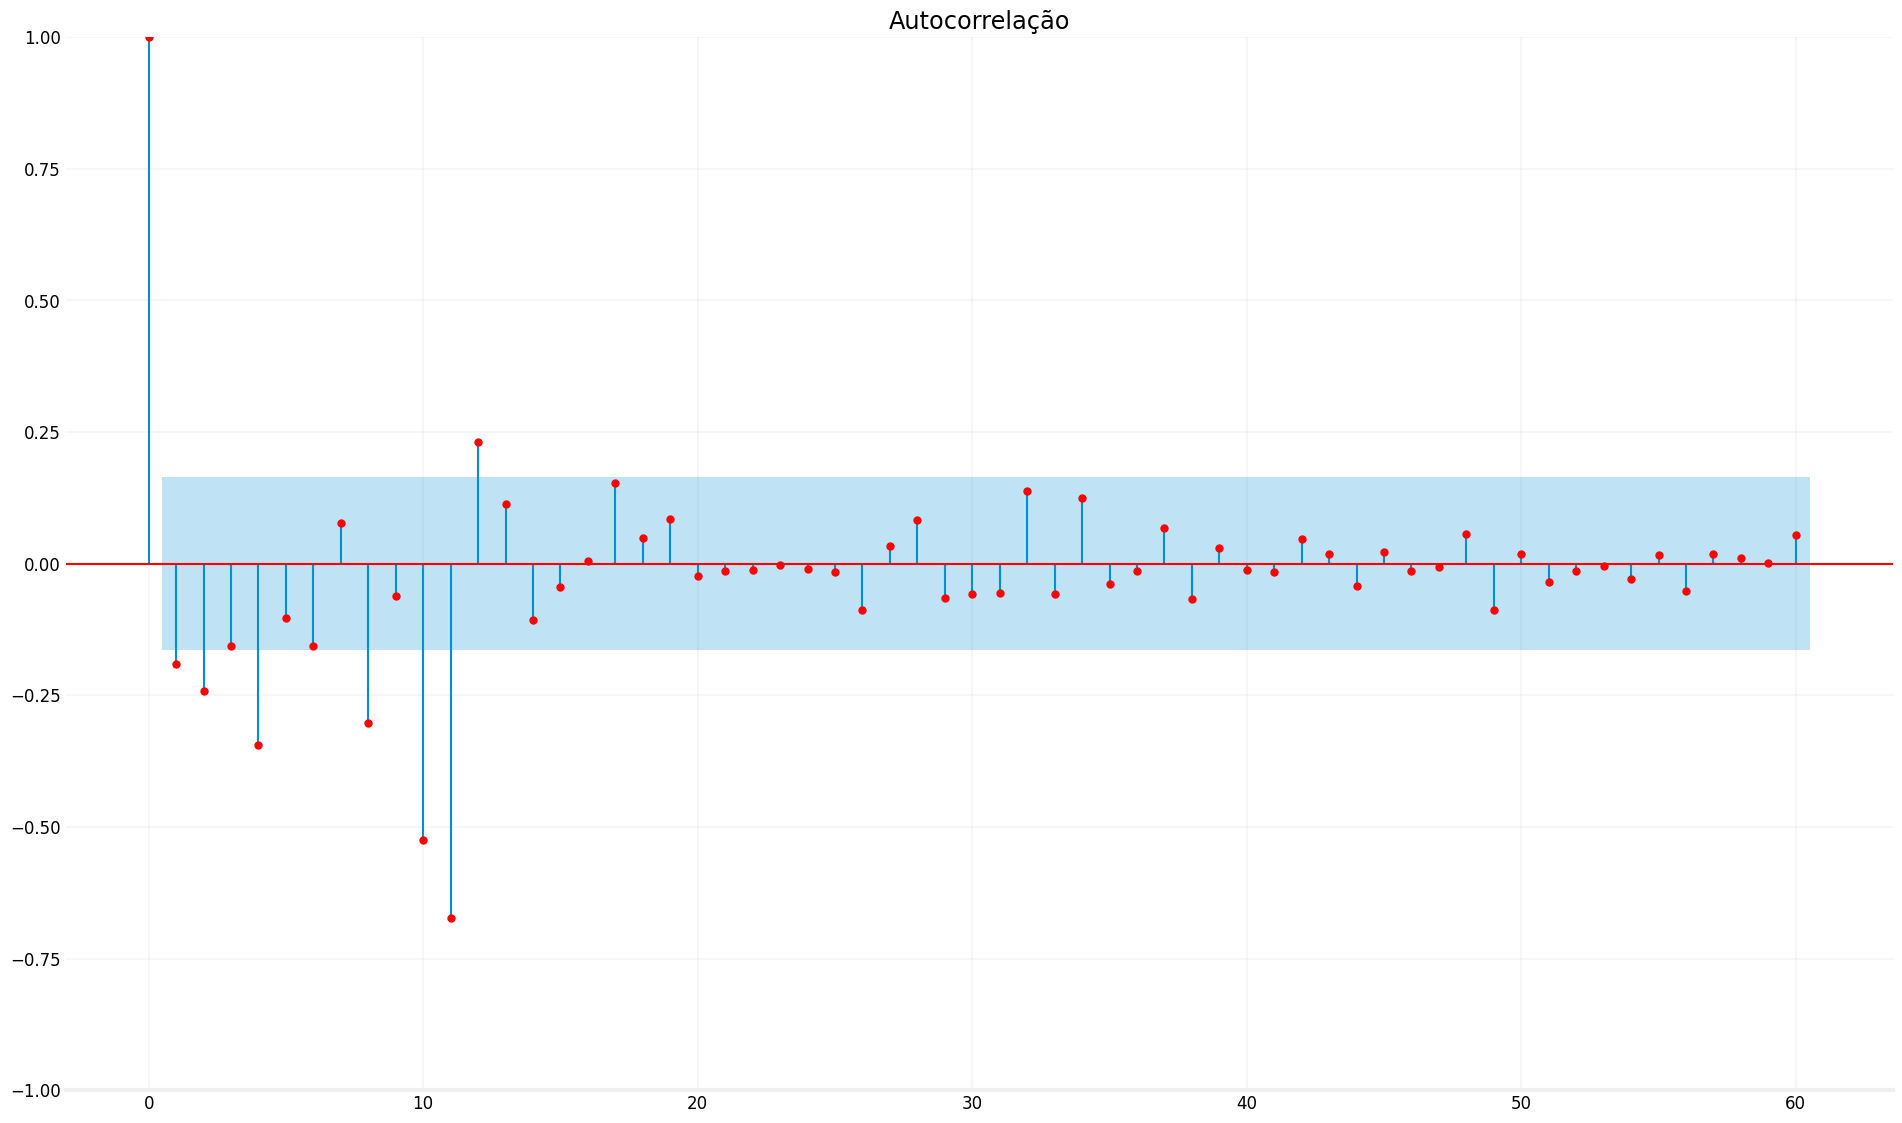

In [ ]:
# Função de correlação parcial para série das diferenças finitas da ordem escolhida acima

plot_pacf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=60, title = "Autocorrelação", color="red");

#### Separação das bases de treino e teste

In [ ]:
# Definição da proporção de dados para compor a base de teste

PercentualTeste = 10

In [ ]:
# Cálculo do tamanho do período de testes
PeriodoTeste = PercentualTeste * len(MinhaSerieTemporal) // 100

# Definição do DataFrame de treino
TreinoDF = pd.DataFrame(index = MinhaSerieTemporal[:-PeriodoTeste].index)
TreinoDF['Treino'] = MinhaSerieTemporal[:-PeriodoTeste][MinhaSerieTemporal.columns[0]]

# Definição do DataFrame de teste
TesteDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
TesteDF['Teste'] = MinhaSerieTemporal[-PeriodoTeste:][MinhaSerieTemporal.columns[0]]

<Axes: xlabel='Mês'>

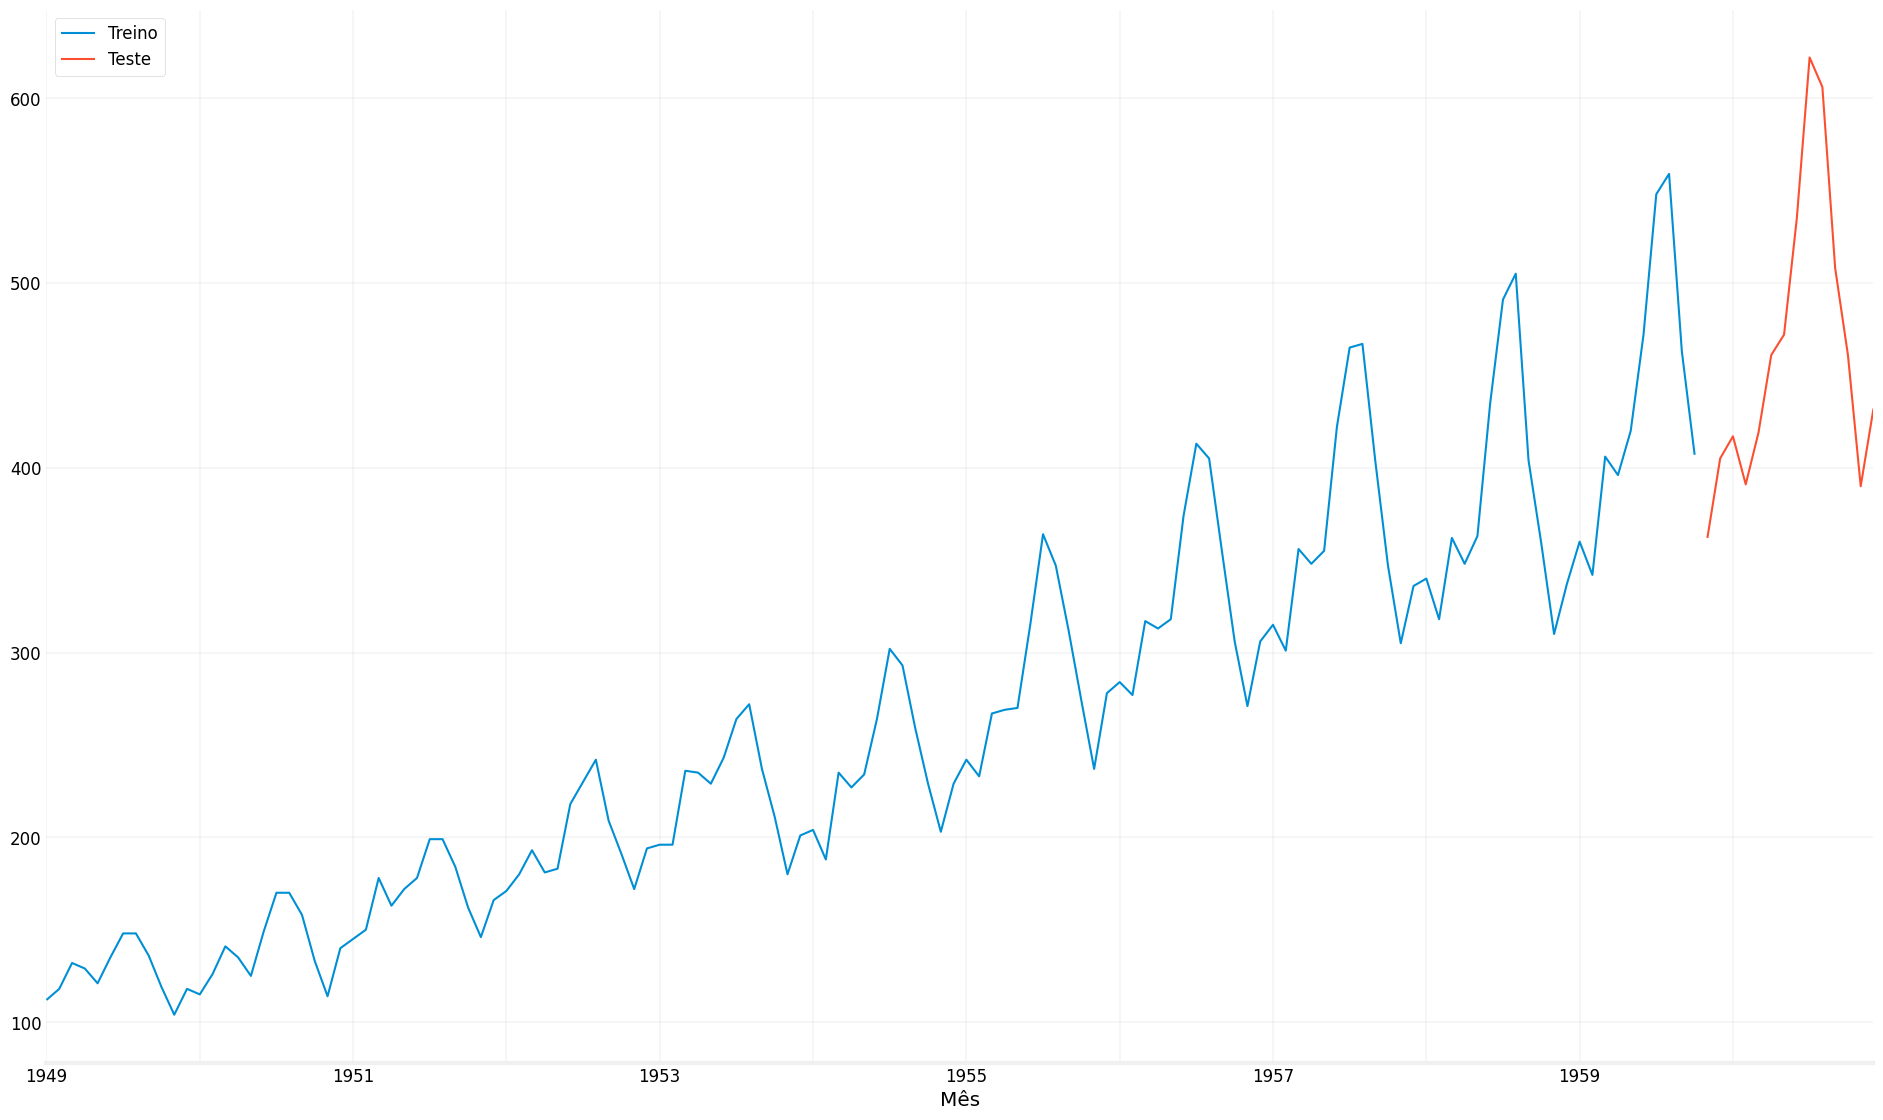

In [ ]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([TreinoDF,TesteDF], axis = 1).plot()

#### Previsão pelo algoritmo AutoARIMA

In [ ]:
# Formatação do DataFrame no padrão do StatsForecast
SerieSF = pd.DataFrame()
SerieSF['ds'] = TreinoDF .index.values
SerieSF['y']  = TreinoDF [TreinoDF.columns[0]].values
SerieSF['unique_id'] = TreinoDF.columns[0]
SerieSF

,ds,y,unique_id
0,1949-01-01,112,Treino
1,1949-02-01,118,Treino
2,1949-03-01,132,Treino
3,1949-04-01,129,Treino
4,1949-05-01,121,Treino
...,...,...,...
125,1959-06-01,472,Treino
126,1959-07-01,548,Treino
127,1959-08-01,559,Treino
128,1959-09-01,463,Treino


In [ ]:
season_length = 12        # anual

InstanteInicial = dt.datetime.now()
models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='y')
sf.fit(df=SerieSF)
InstanteFinal = dt.datetime.now()

arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,0)(0,1,0)[12]                   '

In [ ]:
print(f'Tempo gasto com a função AutoARIMA: {str(InstanteFinal - InstanteInicial)}')

Tempo gasto com a função AutoARIMA: 0:00:00.805111


In [ ]:
# Definição da ordem de autorregressividade
p = 1

# Definição da ordem de integração
d = 1

# Definição da ordem da média móvel
q = 0

# Definição da ordem de autorregressividade sazonal
P = 1

# Definição da ordem de integração sazonal
D = 1

# Definição da ordem da média móvel sazonal
Q = 2

# Período da sazonalidade
m = 12

In [ ]:
InstanteInicial = dt.datetime.now()
model = SARIMAX(TreinoDF, order=(p,d,q), seasonal_order = (P,D,Q,m))
model_fit = model.fit()
InstanteFinal = dt.datetime.now()

C:\Users\leopo\.conda\envs\PUCminas\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leopo\.conda\envs\PUCminas\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
print(f'Tempo gasto com o modelo SARIMA: {str(InstanteFinal - InstanteInicial)}')

Tempo gasto com o modelo SARIMA: 0:00:02.042010


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                  Treino   No. Observations:                  130
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -434.627
Date:                                 Mon, 10 Mar 2025   AIC                            879.255
Time:                                         02:08:07   BIC                            893.066
Sample:                                     01-01-1949   HQIC                           884.862
                                          - 10-01-1959                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3047      0.084     -3.643      0.000      -0.469      -0.141
ar.S.L12       0.9989      0.149      6.682      0.000       0.706       1.292
ma.S.L12      -1.2919      1.937     -0.667      0.505      -5.088       2.505
ma.S.L24       0.3134      0.528      0.594      0.553      -0.721       1.348
sigma2        84.8695    152.508      0.556      0.578    -214.041     383.780
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.95   Prob(JB):                         0.77
Heteroskedasticity (H):               1.55   Skew:                            -0.06
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

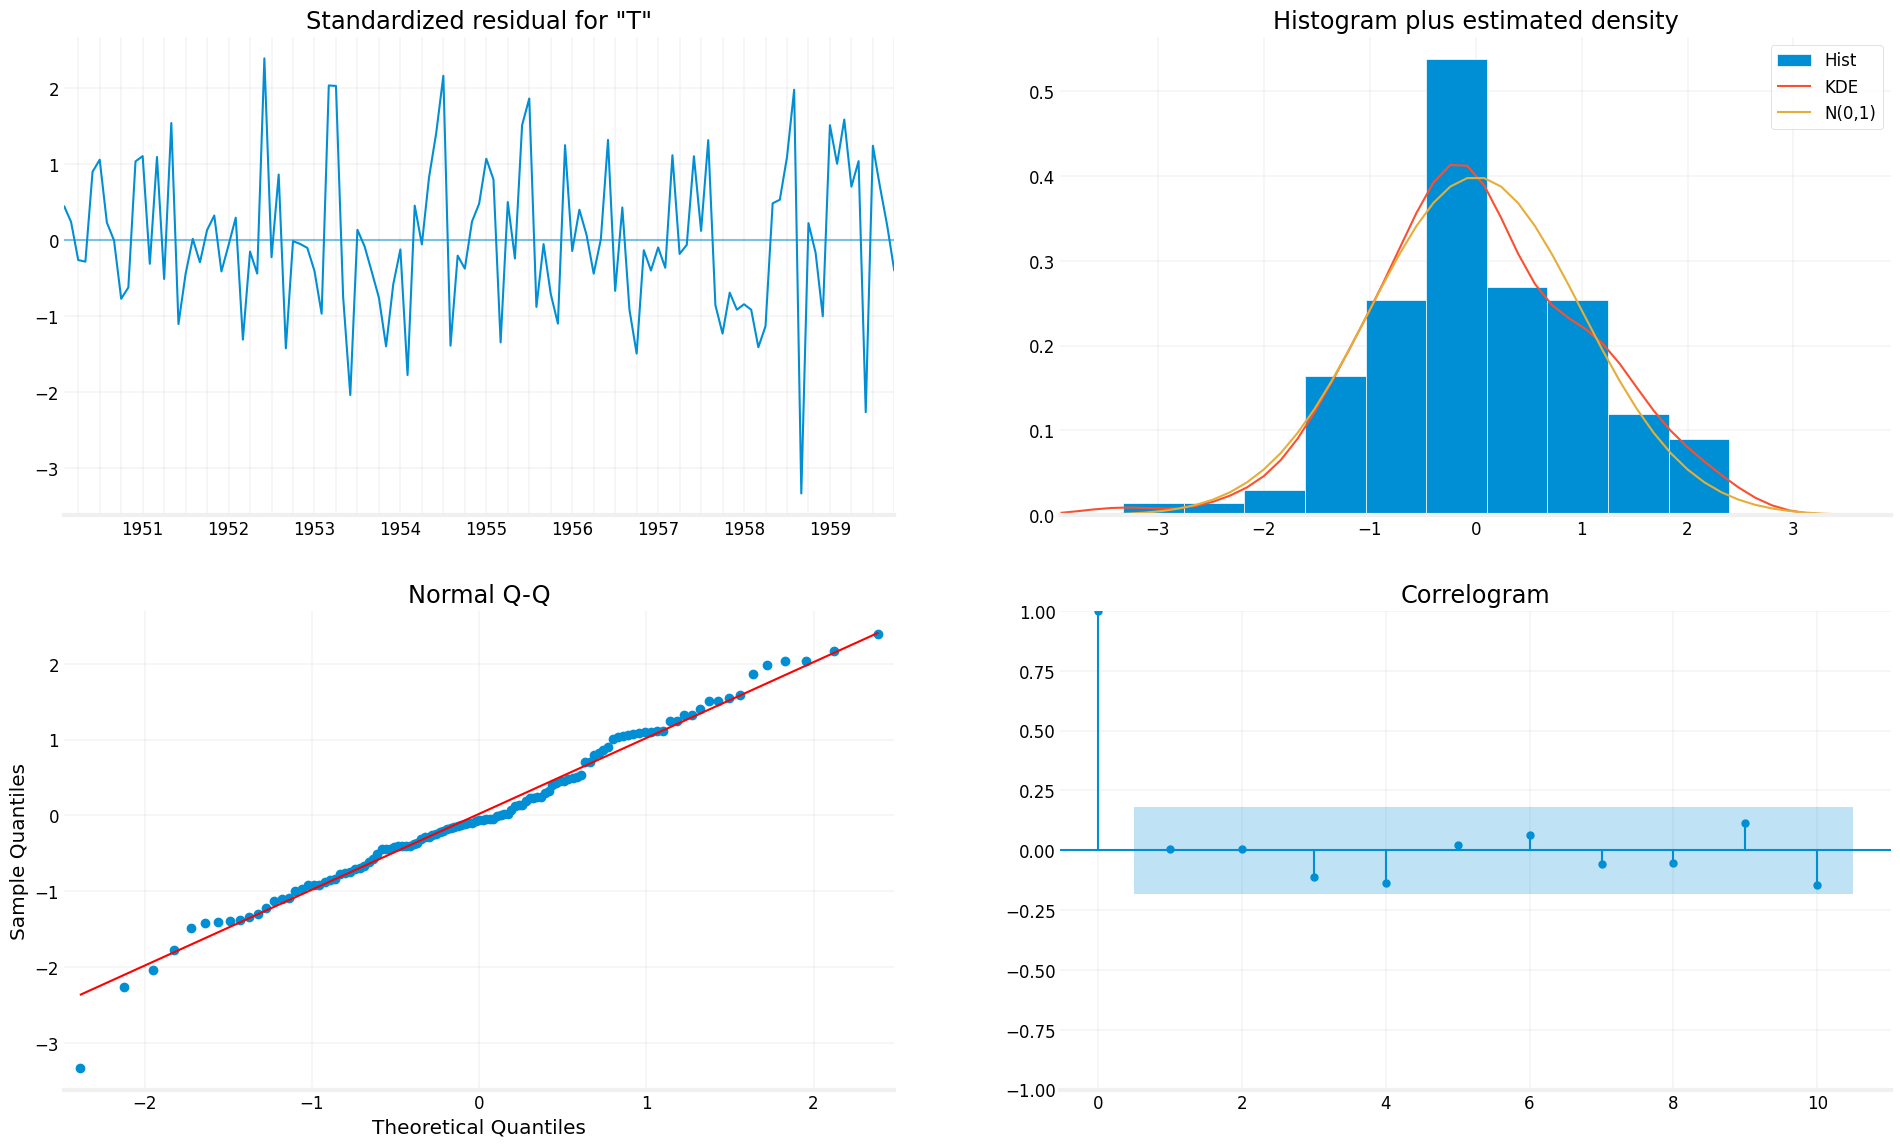

In [ ]:
model_fit.plot_diagnostics();

In [ ]:
PrevisoesSARIMAX = model_fit.get_prediction(len(TreinoDF), len(TreinoDF) + len(TesteDF) - 1).predicted_mean

In [ ]:
# Montagem do DataFrame de previsão

PrevisoesDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
PrevisoesDF['Previsão'] = PrevisoesSARIMAX

<Axes: xlabel='Mês'>

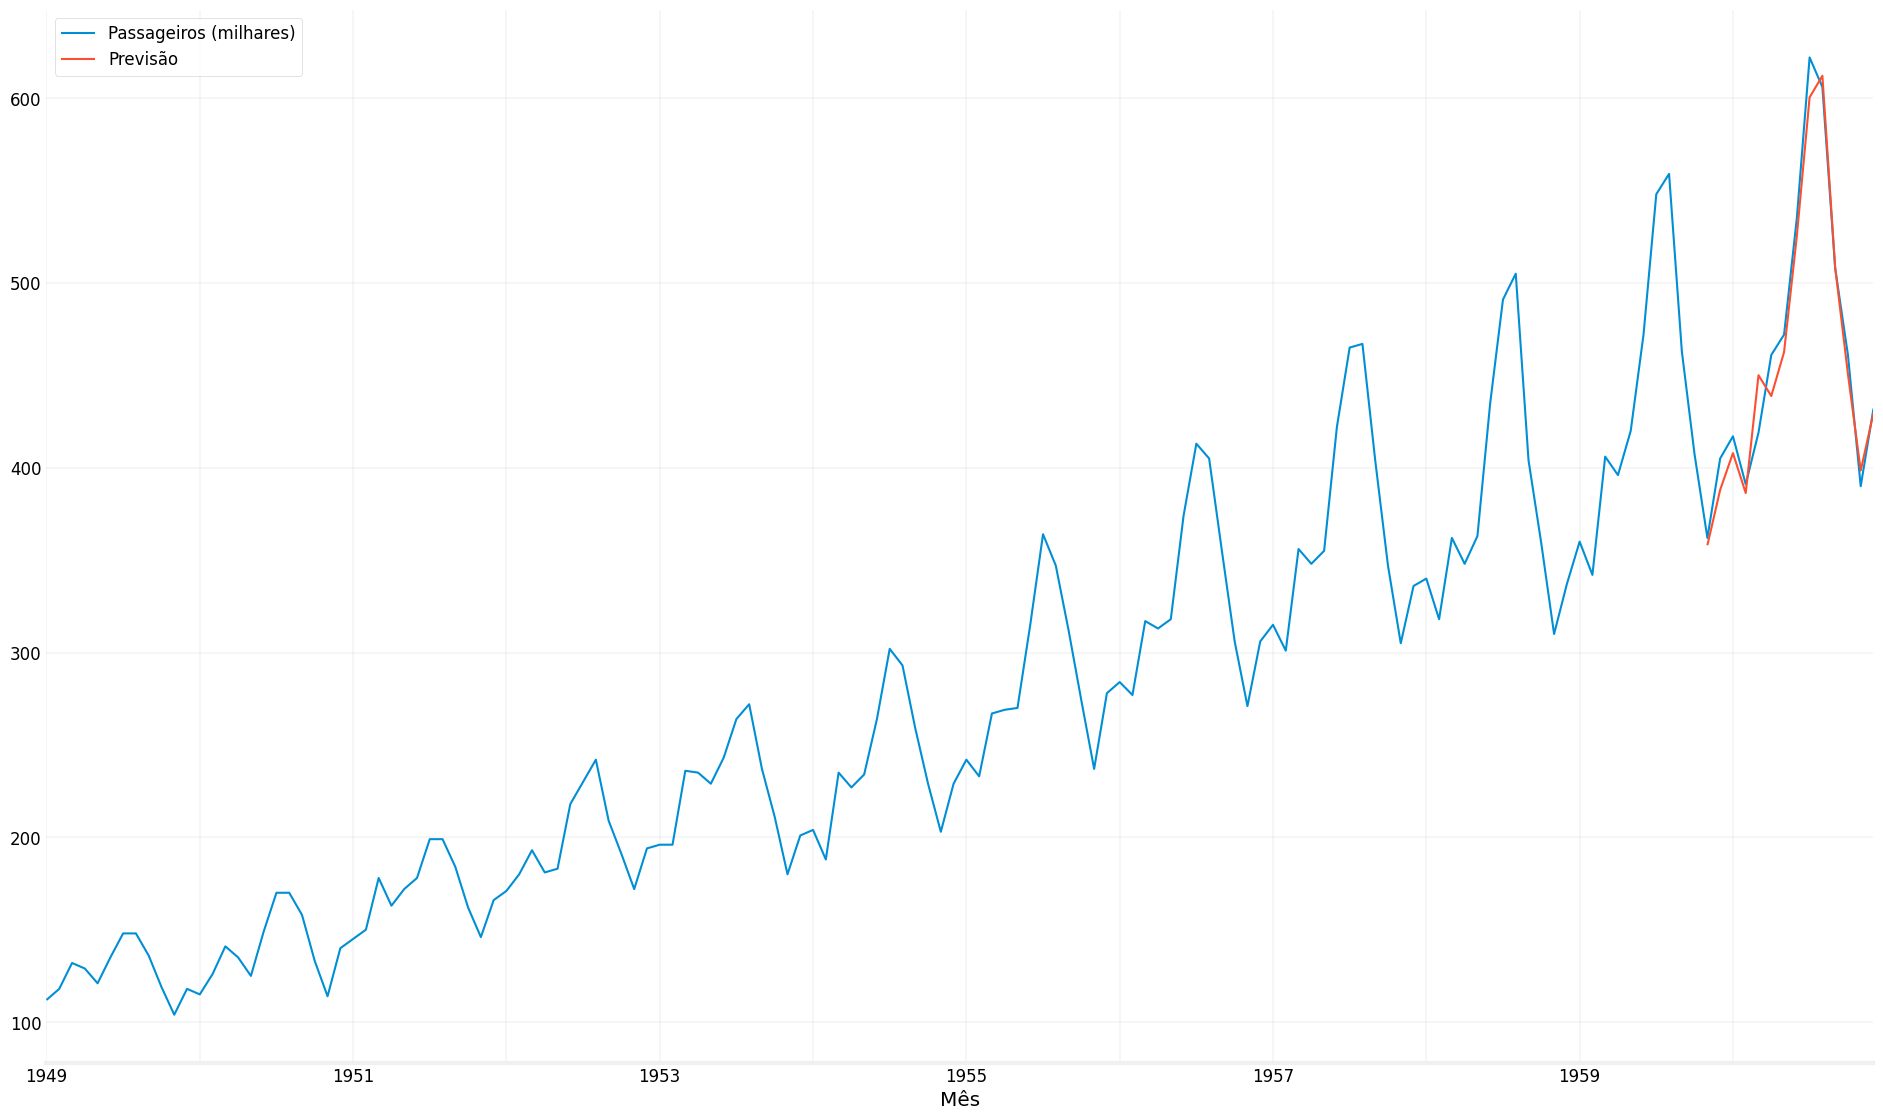

In [ ]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([MinhaSerieTemporal,PrevisoesDF], axis = 1).plot()

#### Medidas de erro

In [ ]:
# Cáluclo do vetor de erros

Erros = PrevisoesDF['Previsão'].values - TesteDF['Teste'].values
Erros

array([ -3.96488307, -16.95609241,  -9.11286129,  -4.7172136 ,
        31.05846715, -22.21325071,  -9.46814225,  -9.67627945,
       -21.60657219,   6.0827166 ,   0.42826492, -10.32443433,
         8.47414767,  -2.29138901])

In [ ]:
# Cálculo do erro médio
ErroMedio = Erros.mean()

In [ ]:
# Cálculo do erro absoluto médio
MAE = np.abs(Erros).mean()

In [ ]:
# Cálculo da raiz do erro quadrático médio
RMSE = np.sqrt((Erros**2).mean())

In [ ]:
# Cálculo dos erros relativos
ErrosRelativos = Erros / TesteDF['Teste'].values
ErrosRelativos

array([-0.01095272, -0.04186689, -0.02185338, -0.01206448,  0.07412522,
       -0.04818493, -0.02005962, -0.0180865 , -0.03473725,  0.01003749,
        0.00084304, -0.02239574,  0.02172858, -0.00530414])

In [ ]:
# Cálculo do erro percentual absoluto médio
MAPE = np.abs(ErrosRelativos).mean()

In [ ]:
print(f'Medidas de erro de previsão')
print()
print(f'Modelo de previsão: SARIMA({p},{d},{q})({P},{D},{Q}){m}')
print()
print(f'Erro médio: {ErroMedio: 2.1f}')
print(f'MAE:        {MAE: 2.1f}')
print(f'RMSE:       {RMSE: 2.1f}')
print(f'MAPE:       {MAPE*100: 2.1f} %')

Medidas de erro de previsão

Modelo de previsão: SARIMA(1,1,0)(1,1,2)12

Erro médio: -4.6
MAE:         11.2
RMSE:        14.0
MAPE:        2.4 %
